This is a version of object detection that goes through the thought process more in depth.

##### Step 1. Loading the Input image/s

In [1]:
# import dependencies 
import os 
os.environ ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# SAM/OpenCLIP dependencies
import torch
import torchvision
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image as Image_Open
from PIL import Image
import open_clip

# COCO dependencies
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
import json

/Users/antoine/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: dlopen(/Users/antoine/miniconda3/lib/python3.10/site-packages/pycocotools/_mask.cpython-310-darwin.so, 0x0002): tried: '/Users/antoine/miniconda3/lib/python3.10/site-packages/pycocotools/_mask.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/antoine/miniconda3/lib/python3.10/site-packages/pycocotools/_mask.cpython-310-darwin.so' (no such file), '/Users/antoine/miniconda3/lib/python3.10/site-packages/pycocotools/_mask.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64'))

Load COCO and initialize the labels from Val 2017 annotations

In [4]:
# Loading COCO
dataDir='..'
dataType='val2017'
annFile='{}/coco/annotations/instances_{}.json'.format(dataDir,dataType)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=1.37s)
creating index...
index created!


In [92]:
# display COCO categories and store them into array 'labels'. Tokenize the labels using OpenCLIP
cats = coco.loadCats(coco.getCatIds())
labels = [(cat['id'], cat['name']) for cat in cats]
labels_id = {label: id for id, label in labels}
print(labels_id)

# Tokenize the labels
labels_tokenized = open_clip.tokenize(["This is " + desc[1] for desc in labels])

{'person': 1, 'bicycle': 2, 'car': 3, 'motorcycle': 4, 'airplane': 5, 'bus': 6, 'train': 7, 'truck': 8, 'boat': 9, 'traffic light': 10, 'fire hydrant': 11, 'stop sign': 13, 'parking meter': 14, 'bench': 15, 'bird': 16, 'cat': 17, 'dog': 18, 'horse': 19, 'sheep': 20, 'cow': 21, 'elephant': 22, 'bear': 23, 'zebra': 24, 'giraffe': 25, 'backpack': 27, 'umbrella': 28, 'handbag': 31, 'tie': 32, 'suitcase': 33, 'frisbee': 34, 'skis': 35, 'snowboard': 36, 'sports ball': 37, 'kite': 38, 'baseball bat': 39, 'baseball glove': 40, 'skateboard': 41, 'surfboard': 42, 'tennis racket': 43, 'bottle': 44, 'wine glass': 46, 'cup': 47, 'fork': 48, 'knife': 49, 'spoon': 50, 'bowl': 51, 'banana': 52, 'apple': 53, 'sandwich': 54, 'orange': 55, 'broccoli': 56, 'carrot': 57, 'hot dog': 58, 'pizza': 59, 'donut': 60, 'cake': 61, 'chair': 62, 'couch': 63, 'potted plant': 64, 'bed': 65, 'dining table': 67, 'toilet': 70, 'tv': 72, 'laptop': 73, 'mouse': 74, 'remote': 75, 'keyboard': 76, 'cell phone': 77, 'microwave

Load input image using COCO

In [106]:
# randomly sample an image from COCO Val split 2017
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','dog']);
imgIds = coco.getImgIds(catIds=catIds );
# imgIds = coco.getImgIds(imgIds = [324158]) # uncomment to get a specific image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
image_id = img['id']

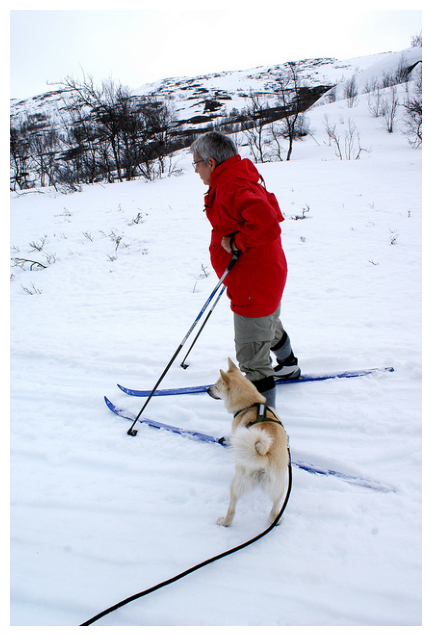

In [107]:
# load and display image
image = io.imread(img['coco_url']) 

# tempImg to be cropped for some functions
tempImg = Image.fromarray(image) 
plt.imshow(tempImg)
plt.axis('off')
plt.show() 

Load input image locally

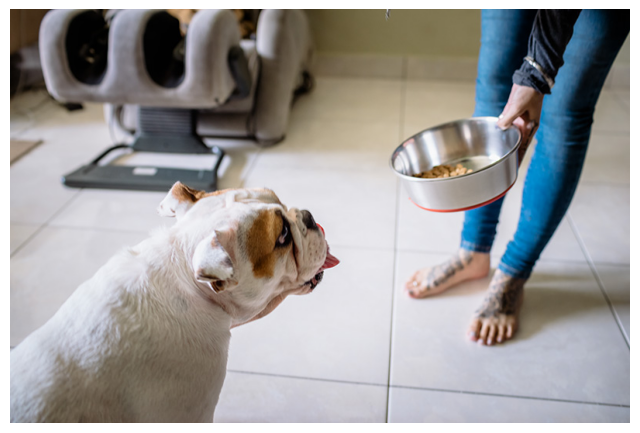

In [7]:
# load and display image
image = cv2.imread('images/dog.jpg') 
# convert image to be readable by SAM
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# tempImg to be cropped for some functions
tempImg = Image.fromarray(image)
plt.imshow(tempImg)
plt.axis('off')
plt.show() 

##### Step 2. Segment Anything Output

In [8]:
# Loading SAM Model
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Loading SAM Predictor
mask_generator = SamAutomaticMaskGenerator(sam)

In [108]:
# Run automatic mask generation
masks = mask_generator.generate(image)
length_masks = len(masks)

In [10]:
# Loading OpenCLIP
model, _, transform = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k"
)

##### Step 3. Cropping the image depending on the SAM output (masks)

In [11]:
def get_cropped_image(mask):
    # convert the XYWH bounding box to LURD format
    bbox_xywh = masks[mask]['bbox'] # the SAM model returns the bounding box in xywh format
    bbox_lurd = [bbox_xywh[0], bbox_xywh[1], bbox_xywh[0] + bbox_xywh[2], 
    bbox_xywh[1] + bbox_xywh[3]] # convert the bounding box to LURD format
    
    # Crop the image using the bounding box coordinates
    cropped_image = tempImg.crop(bbox_lurd) 
    display_image = cropped_image.convert("RGB")
    cropped_image = transform(display_image).unsqueeze(0)
    
    return cropped_image, display_image

##### Step 4. Getting the output label prediction from openCLIP.

In [12]:
# Run through all the masks and then crop image to ask OpenClip "This is a photo of what?"
def get_label(mask):
    # crop the image AKA get the bounding box
    cropped_image, display_image = get_cropped_image(mask)
    
    # ask OpenClip "This is a photo of what?"
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(cropped_image).float()
        text_features = model.encode_text(labels_tokenized).float()
    
    # Normalize the features and calculate the dot product of each pair.
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    
    # Get the predicted label
    predicted_label_index = similarity.argmax()
    predicted_label = labels[predicted_label_index]
    
    # get the top 2 probabilities and labels
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_labels = text_probs.cpu().topk(2, dim=-1)
    
    # return the highest probability label and its percentage
    return labels[top_labels[0][0].item()], top_probs[0][0].item(), labels[top_labels[0][1].item()], top_probs[0][1].item()

    # print("predicted label: ", predicted_label)
    # print("top_labels:\n1. ", labels[top_labels[0][0].item()], ": ", top_probs[0][0].item(),
    #       "\n2. ", labels[top_labels[0][1].item()], ": ", top_probs[0][1].item())
    
    # plt.axis('off')
    # plt.imshow(display_image)
    # plt.show()

((18, 'dog'), 0.5803560018539429)
[206, 362, 83, 173]
[206, 362, 289, 535]


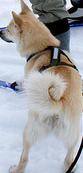

In [116]:
test_id = 6
print(get_label(test_id))

bbox_xywh = masks[test_id]['bbox']
print(bbox_xywh)
# Convert the bounding box to LURD format
bbox_lurd = [bbox_xywh[0], bbox_xywh[1], bbox_xywh[0] + bbox_xywh[2],bbox_xywh[1] + bbox_xywh[3]]
print(bbox_lurd)

cropped_image = tempImg.crop(bbox_lurd) # Crop the image using the bounding box coordinates
cropped_image.convert("RGB")

In [ ]:
# create a dictionary of labels and the corresponding probabilities
label_dict = []
for mask in range(length_masks):
    label1, probability1, label2, probability2 = get_label(mask)
    label_dict.append({"category_id": label1[0], 
                       "bbox": masks[mask]['bbox'], "score": probability1})
    label_dict.append({"category_id": label2[0], 
                       "bbox": masks[mask]['bbox'], "score": probability2})

In [19]:
label_dict = [{'image_id': 80153, 'category_id': 35, 'bbox': [0, 81, 427, 558], 'score': 0.9992744326591492}, {'image_id': 80153, 'category_id': 36, 'bbox': [0, 0, 427, 91], 'score': 0.6077811121940613}, {'image_id': 80153, 'category_id': 35, 'bbox': [202, 150, 85, 188], 'score': 0.8669075965881348}, {'image_id': 80153, 'category_id': 74, 'bbox': [187, 126, 49, 34], 'score': 0.24133776128292084}, {'image_id': 80153, 'category_id': 35, 'bbox': [151, 126, 150, 409], 'score': 0.9994683861732483}, {'image_id': 80153, 'category_id': 35, 'bbox': [187, 126, 114, 286], 'score': 0.9978146553039551}, {'image_id': 80153, 'category_id': 18, 'bbox': [206, 362, 83, 173], 'score': 0.5803560018539429}, {'image_id': 80153, 'category_id': 65, 'bbox': [251, 380, 24, 17], 'score': 0.24015702307224274}, {'image_id': 80153, 'category_id': 1, 'bbox': [233, 307, 51, 42], 'score': 0.26342251896858215}, {'image_id': 80153, 'category_id': 36, 'bbox': [0, 69, 169, 117], 'score': 0.5160307884216309}, {'image_id': 80153, 'category_id': 39, 'bbox': [251, 380, 24, 33], 'score': 0.23950086534023285}, {'image_id': 80153, 'category_id': 1, 'bbox': [417, 24, 10, 13], 'score': 0.19869676232337952}, {'image_id': 80153, 'category_id': 35, 'bbox': [226, 290, 58, 95], 'score': 0.5034642815589905}, {'image_id': 80153, 'category_id': 15, 'bbox': [326, 108, 47, 47], 'score': 0.2462030053138733}, {'image_id': 80153, 'category_id': 18, 'bbox': [72, 454, 221, 185], 'score': 0.8178400993347168}, {'image_id': 80153, 'category_id': 63, 'bbox': [234, 344, 40, 41], 'score': 0.17686030268669128}, {'image_id': 80153, 'category_id': 1, 'bbox': [190, 150, 24, 32], 'score': 0.8841147422790527}, {'image_id': 80153, 'category_id': 39, 'bbox': [261, 391, 14, 22], 'score': 0.08251822739839554}, {'image_id': 80153, 'category_id': 35, 'bbox': [387, 46, 27, 33], 'score': 0.255812406539917}, {'image_id': 80153, 'category_id': 85, 'bbox': [347, 67, 13, 34], 'score': 0.06912384182214737}, {'image_id': 80153, 'category_id': 72, 'bbox': [296, 107, 15, 24], 'score': 0.1121295839548111}, {'image_id': 80153, 'category_id': 32, 'bbox': [233, 316, 41, 69], 'score': 0.11272279918193817}, {'image_id': 80153, 'category_id': 1, 'bbox': [387, 79, 15, 48], 'score': 0.34468522667884827}, {'image_id': 80153, 'category_id': 6, 'bbox': [329, 80, 9, 16], 'score': 0.12406154721975327}, {'image_id': 80153, 'category_id': 1, 'bbox': [409, 60, 18, 83], 'score': 0.11215370148420334}, {'image_id': 80153, 'category_id': 16, 'bbox': [242, 86, 24, 72], 'score': 0.1237453892827034}, {'image_id': 80153, 'category_id': 35, 'bbox': [372, 79, 30, 47], 'score': 0.6107750535011292}, {'image_id': 80153, 'category_id': 72, 'bbox': [51, 140, 31, 16], 'score': 0.06565067172050476}, {'image_id': 80153, 'category_id': 5, 'bbox': [11, 283, 21, 12], 'score': 0.1153164952993393}, {'image_id': 80153, 'category_id': 42, 'bbox': [46, 205, 17, 9], 'score': 0.09783181548118591}, {'image_id': 80153, 'category_id': 18, 'bbox': [205, 361, 59, 74], 'score': 0.9735325574874878}, {'image_id': 80153, 'category_id': 3, 'bbox': [174, 109, 35, 9], 'score': 0.37489190697669983}, {'image_id': 80153, 'category_id': 35, 'bbox': [293, 467, 107, 34], 'score': 0.5568870306015015}, {'image_id': 80153, 'category_id': 1, 'bbox': [342, 108, 4, 9], 'score': 0.26104986667633057}, {'image_id': 80153, 'category_id': 5, 'bbox': [75, 230, 11, 10], 'score': 0.16270121932029724}, {'image_id': 80153, 'category_id': 42, 'bbox': [172, 108, 47, 12], 'score': 0.736384391784668}, {'image_id': 80153, 'category_id': 72, 'bbox': [371, 79, 16, 31], 'score': 0.16257144510746002}, {'image_id': 80153, 'category_id': 39, 'bbox': [271, 334, 21, 30], 'score': 0.12302891910076141}, {'image_id': 80153, 'category_id': 42, 'bbox': [111, 389, 96, 12], 'score': 0.2338147908449173}, {'image_id': 80153, 'category_id': 77, 'bbox': [233, 408, 50, 25], 'score': 0.5319007039070129}, {'image_id': 80153, 'category_id': 3, 'bbox': [49, 181, 25, 10], 'score': 0.08356828987598419}, {'image_id': 80153, 'category_id': 16, 'bbox': [20, 234, 18, 16], 'score': 0.18542104959487915}, {'image_id': 80153, 'category_id': 62, 'bbox': [271, 333, 17, 20], 'score': 0.29896634817123413}, {'image_id': 80153, 'category_id': 1, 'bbox': [246, 67, 5, 4], 'score': 0.13703912496566772}, {'image_id': 80153, 'category_id': 1, 'bbox': [112, 201, 3, 8], 'score': 0.3174571692943573}, {'image_id': 80153, 'category_id': 35, 'bbox': [299, 78, 35, 27], 'score': 0.2851182520389557}, {'image_id': 80153, 'category_id': 1, 'bbox': [176, 87, 5, 4], 'score': 0.30611705780029297}, {'image_id': 80153, 'category_id': 35, 'bbox': [177, 287, 46, 85], 'score': 0.9533762335777283}, {'image_id': 80153, 'category_id': 1, 'bbox': [61, 249, 4, 5], 'score': 0.19551792740821838}, {'image_id': 80153, 'category_id': 5, 'bbox': [34, 251, 16, 13], 'score': 0.11174891889095306}, {'image_id': 80153, 'category_id': 72, 'bbox': [387, 63, 14, 17], 'score': 0.09503377228975296}, {'image_id': 80153, 'category_id': 35, 'bbox': [271, 334, 30, 49], 'score': 0.12780356407165527}, {'image_id': 80153, 'category_id': 39, 'bbox': [292, 202, 19, 15], 'score': 0.11434153467416763}, {'image_id': 80153, 'category_id': 42, 'bbox': [183, 108, 35, 10], 'score': 0.2893866300582886}]

In [20]:
# Gather all the bbox's for one category to be used for batched prompt inputs
from collections import defaultdict

boxes_dict = defaultdict(list)
for item in label_dict:
    boxes_dict[item['category_id']].append(item['bbox'])

for category_id, boxes in boxes_dict.items():
    tensor_name = f"{category_id}_boxes"
    tensor_value = torch.tensor(boxes)
    globals()[tensor_name] = tensor_value


In [23]:
# sort the boxes_dict and then store into tensor_array
tensor_array = []
def sort_bbox(boxes_dict):
    for category_id in boxes_dict.keys():
        tensor_name = f"{category_id}_boxes"
        if tensor_name in globals():
            tensor_value = globals()[tensor_name]
            tensor_array.append({tensor_name: tensor_value})
            print(f"{tensor_name}: {tensor_value}")

sort_bbox(boxes_dict)

35_boxes: tensor([[  0,  81, 427, 558],
        [202, 150,  85, 188],
        [151, 126, 150, 409],
        [187, 126, 114, 286],
        [226, 290,  58,  95],
        [387,  46,  27,  33],
        [372,  79,  30,  47],
        [293, 467, 107,  34],
        [299,  78,  35,  27],
        [177, 287,  46,  85],
        [271, 334,  30,  49]])
36_boxes: tensor([[  0,   0, 427,  91],
        [  0,  69, 169, 117]])
74_boxes: tensor([[187, 126,  49,  34]])
18_boxes: tensor([[206, 362,  83, 173],
        [ 72, 454, 221, 185],
        [205, 361,  59,  74]])
65_boxes: tensor([[251, 380,  24,  17]])
1_boxes: tensor([[233, 307,  51,  42],
        [417,  24,  10,  13],
        [190, 150,  24,  32],
        [387,  79,  15,  48],
        [409,  60,  18,  83],
        [342, 108,   4,   9],
        [246,  67,   5,   4],
        [112, 201,   3,   8],
        [176,  87,   5,   4],
        [ 61, 249,   4,   5]])
39_boxes: tensor([[251, 380,  24,  33],
        [261, 391,  14,  22],
        [271, 334,  21,  

In [ ]:
# iterate through tensor_array and then create a batched prompt for each category


In [ ]:
    label_dict.append({"image_id": image_id, "category_id": label[0], 
                       "bbox": masks[mask]['bbox'], "score": probability})
    print(mask, label[1], label_dict[mask])
    # {"image_id":42,"category_id":18,"bbox":[258.15,41.29,348.26,243.78],"score":0.236}
    
# sort the label_dict
# 1. Sort the dictionary by label, and get the e

In [125]:
print(label_dict)

[{'image_id': 80153, 'category_id': 35, 'bbox': [0, 81, 427, 558], 'score': 0.9992744326591492}, {'image_id': 80153, 'category_id': 36, 'bbox': [0, 0, 427, 91], 'score': 0.6077811121940613}, {'image_id': 80153, 'category_id': 35, 'bbox': [202, 150, 85, 188], 'score': 0.8669075965881348}, {'image_id': 80153, 'category_id': 74, 'bbox': [187, 126, 49, 34], 'score': 0.24133776128292084}, {'image_id': 80153, 'category_id': 35, 'bbox': [151, 126, 150, 409], 'score': 0.9994683861732483}, {'image_id': 80153, 'category_id': 35, 'bbox': [187, 126, 114, 286], 'score': 0.9978146553039551}, {'image_id': 80153, 'category_id': 18, 'bbox': [206, 362, 83, 173], 'score': 0.5803560018539429}, {'image_id': 80153, 'category_id': 65, 'bbox': [251, 380, 24, 17], 'score': 0.24015702307224274}, {'image_id': 80153, 'category_id': 1, 'bbox': [233, 307, 51, 42], 'score': 0.26342251896858215}, {'image_id': 80153, 'category_id': 36, 'bbox': [0, 69, 169, 117], 'score': 0.5160307884216309}, {'image_id': 80153, 'categ

##### Step 5. If label is in COCO: compare prediction with ground truth score using mAP, Else: ignore

In [126]:
# import dependencies for COCO evaluation
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [127]:
annType = ['segm','bbox','keypoints']
annType = annType[1]      #specify type here
prefix = 'person_keypoints' if annType=='keypoints' else 'instances'
print('Running demo for *%s* results.'%(annType))

Running demo for *bbox* results.


In [128]:
#initialize COCO ground truth api
dataDir='../'
dataType='val2017'
prefix = 'instances'
annFile = '%s/coco/annotations/%s_%s.json'%(dataDir,prefix,dataType)
cocoGt=COCO(annFile)

loading annotations into memory...
Done (t=1.05s)
creating index...
index created!


In [133]:
# initialize COCO detections api
resFile='%s/coco/results/%s_%s_fake%s100_results.json'%(dataDir, prefix, dataType, annType)

# save the label_dict to a json file
with open(resFile, 'w') as f:
    json.dump(label_dict, f)

# load results in COCO evaluation tool    
cocoDt=cocoGt.loadRes(resFile)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


In [134]:
imgIds=sorted(cocoGt.getImgIds())
imgIds=imgIds[0:100]
imgId = imgIds[np.random.randint(100)]

In [135]:
# running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.31s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100